# 1. Import Dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

## How to get new data
Remember to do a backup before to proceed, look at backup\appunti.txt.

To generate new data pen scripts\getDataHandGesture.py and edit labels adding new gestures. 

Execute it to export data in src\dataHandGesture

## How to export and use the generated model
At the end of the execution the generated model will be here: Tensorflow\workspace\models

Then, copy the name of the folder inside Tensorflow\workspace\models\my_hand_gesture_model\ (not eval, should be something like 1642800231) and paste in
scripts\handGestureModule.py in the first variable named "lastModel"

## Dataset
This specific dataset seperates hand gestures into 10 different classes.

<img style="float: center;" src="document\images\gestures.png">

- backward:
    > this command allows the drone to go backwards;
- detect:
    > this command allows you to detect a 3d trajectory;
- down: 
    > this command allows the drone to go down;
- forward: 
    > this command allows the drone to go forward;
- land:
    > this command allows the drone to land;
- left:
    > this command allows the drone to go left;
- ok:
    > this command allows the drone to go close and execute a 3d trajectory;
- right:
    > this command allows the drone to go right;
- stop:
    > this command allows the drone to stop his movements;
- up:
    > this command allows the drone to go up.

The information about each hand gesture is contained into 42 features.

In [2]:
# CSV_COLUMN_NAMES = np.arange(43)
# CSV_COLUMN_NAMES = [str(item) for item in CSV_COLUMN_NAMES]

CSV_COLUMN_NAMES = ["WRIST_X", "WRIST_Y",
                    "THUMB_CMC_X", "THUMB_CMC_Y",
                    "THUMB_MCP_X", "THUMB_MCP_Y",
                    "THUMB_IP_X", "THUMB_IP_Y",
                    "THUMB_TIP_X", "THUMB_TIP_Y",
                    "INDEX_FINGER_MCP_X", "INDEX_FINGER_MCP_Y",
                    "INDEX_FINGER_PIP_X", "INDEX_FINGER_PIP_Y",
                    "INDEX_FINGER_DIP_X", "INDEX_FINGER_DIP_Y",
                    "INDEX_FINGER_TIP_X", "INDEX_FINGER_TIP_Y",
                    "MIDDLE_FINGER_MCP_X", "MIDDLE_FINGER_MCP_Y",
                    "MIDDLE_FINGER_PIP_X", "MIDDLE_FINGER_PIP_Y",
                    "MIDDLE_FINGER_DIP_X", "MIDDLE_FINGER_DIP_Y",
                    "MIDDLE_FINGER_TIP_X", "MIDDLE_FINGER_TIP_Y",
                    "RING_FINGER_MCP_X", "RING_FINGER_MCP_Y",
                    "RING_FINGER_PIP_X", "RING_FINGER_PIP_Y",
                    "RING_FINGER_DIP_X", "RING_FINGER_DIP_Y",
                    "RING_FINGER_TIP_X", "RING_FINGER_TIP_Y",
                    "PINKY_MCP_X", "PINKY_MCP_Y",
                    "PINKY_PIP_X", "PINKY_PIP_Y",
                    "PINKY_DIP_X", "PINKY_DIP_Y",
                    "PINKY_TIP_X", "PINKY_TIP_Y",
                    "TARGET"]

TARGET = ['backward', 'detect', 'down', 'forward', 'land', 'left', 'ok', 'right', 'stop', 'up']
CSV_PATH = os.path.join("src", "dataHandGesture", "file_0.csv")

In [3]:
df = pd.read_csv(CSV_PATH, names=CSV_COLUMN_NAMES, header=0)

# Convert target to have TARGET values
df.TARGET = df.TARGET.apply(np.int32)
y = pd.Series(list(np.take(TARGET, df.TARGET)), index=df.TARGET.index, name="TARGET")

# Split the dataset
train=df.sample(frac=0.75,random_state=200) #random state is a seed value
test=df.drop(train.index)

In [4]:
# Head method show only first 5 rows
train.head()

,WRIST_X,WRIST_Y,THUMB_CMC_X,THUMB_CMC_Y,THUMB_MCP_X,THUMB_MCP_Y,THUMB_IP_X,THUMB_IP_Y,THUMB_TIP_X,THUMB_TIP_Y,...,RING_FINGER_TIP_Y,PINKY_MCP_X,PINKY_MCP_Y,PINKY_PIP_X,PINKY_PIP_Y,PINKY_DIP_X,PINKY_DIP_Y,PINKY_TIP_X,PINKY_TIP_Y,TARGET
674,-0.627156,-0.237030,-0.577802,0.087291,-0.394490,0.418663,-0.281683,0.700682,-0.274632,0.961549,...,-0.244080,-0.027866,-0.462645,0.254153,-0.427393,0.141345,-0.434443,0.014437,-0.441493,6
233,-0.415663,0.819089,-0.008018,0.774779,0.257838,0.446891,0.346457,0.101278,0.346457,-0.137992,...,0.039245,-0.513144,0.119002,-0.380216,-0.297505,-0.415663,-0.146854,-0.442249,0.048107,2
739,-0.777230,-0.629216,-0.261386,-0.364681,0.228004,-0.166279,0.518993,0.005669,0.704168,0.177617,...,0.481832,-0.578829,-0.219186,-0.525922,0.071803,-0.499468,0.283431,-0.473014,0.415699,7
865,-0.386138,-0.922441,0.185643,-0.749174,0.653465,-0.437293,0.774752,-0.056106,0.514851,0.099835,...,-0.108086,-0.680692,0.151815,-0.576732,0.307755,-0.542078,0.013201,-0.594058,-0.073432,8
523,-0.112126,-0.993694,-0.281323,-0.683500,-0.323622,-0.316908,-0.267223,-0.049013,-0.182625,0.148383,...,0.444477,0.367264,-0.345107,0.451862,-0.049013,0.508261,0.162482,0.550560,0.345779,5


In [5]:
train_y = train.pop('TARGET')
test_y = test.pop('TARGET')

train.head() # the TARGET column is now gone

,WRIST_X,WRIST_Y,THUMB_CMC_X,THUMB_CMC_Y,THUMB_MCP_X,THUMB_MCP_Y,THUMB_IP_X,THUMB_IP_Y,THUMB_TIP_X,THUMB_TIP_Y,...,RING_FINGER_TIP_X,RING_FINGER_TIP_Y,PINKY_MCP_X,PINKY_MCP_Y,PINKY_PIP_X,PINKY_PIP_Y,PINKY_DIP_X,PINKY_DIP_Y,PINKY_TIP_X,PINKY_TIP_Y
674,-0.627156,-0.237030,-0.577802,0.087291,-0.394490,0.418663,-0.281683,0.700682,-0.274632,0.961549,...,0.042639,-0.244080,-0.027866,-0.462645,0.254153,-0.427393,0.141345,-0.434443,0.014437,-0.441493
233,-0.415663,0.819089,-0.008018,0.774779,0.257838,0.446891,0.346457,0.101278,0.346457,-0.137992,...,-0.229564,0.039245,-0.513144,0.119002,-0.380216,-0.297505,-0.415663,-0.146854,-0.442249,0.048107
739,-0.777230,-0.629216,-0.261386,-0.364681,0.228004,-0.166279,0.518993,0.005669,0.704168,0.177617,...,-0.129118,0.481832,-0.578829,-0.219186,-0.525922,0.071803,-0.499468,0.283431,-0.473014,0.415699
865,-0.386138,-0.922441,0.185643,-0.749174,0.653465,-0.437293,0.774752,-0.056106,0.514851,0.099835,...,-0.282178,-0.108086,-0.680692,0.151815,-0.576732,0.307755,-0.542078,0.013201,-0.594058,-0.073432
523,-0.112126,-0.993694,-0.281323,-0.683500,-0.323622,-0.316908,-0.267223,-0.049013,-0.182625,0.148383,...,0.310865,0.444477,0.367264,-0.345107,0.451862,-0.049013,0.508261,0.162482,0.550560,0.345779


In [6]:
# 75% of all dataset with 42 features
train.shape  

(749, 42)

# Data Visualization
We'll just do a few quick plots of the data.

In [7]:
# Data visualization library  
import seaborn as sns

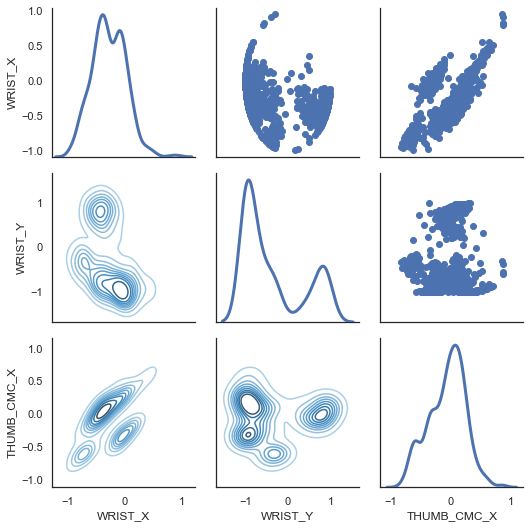

In [8]:
# What about three or more feauture comparision ? For this purpose we can use pair grid plot. Also it seems very cool :) And we discover one more thing radius_worst, 
# perimeter_worst and area_worst are correlated as it can be seen pair grid plot. We definetely use these discoveries for feature selection.

sns.set(style="white")
x = df.loc[:,["WRIST_X","WRIST_Y", "THUMB_CMC_X"]]
g = sns.PairGrid(x, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

g:\Bicocca\_Universita\Laurea Magistrale\Tesi magistrale\tfod\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 26.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
g:\Bicocca\_Universita\Laurea Magistrale\Tesi magistrale\tfod\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 55.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
g:\Bicocca\_Universita\Laurea Magistrale\Tesi magistrale\tfod\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 27.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
g:\Bicocca\_Universita\Laurea Magistrale\Tesi magistrale\tfod\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 51.3% of the points cannot be placed; you may want to decrease the size of the markers or use s

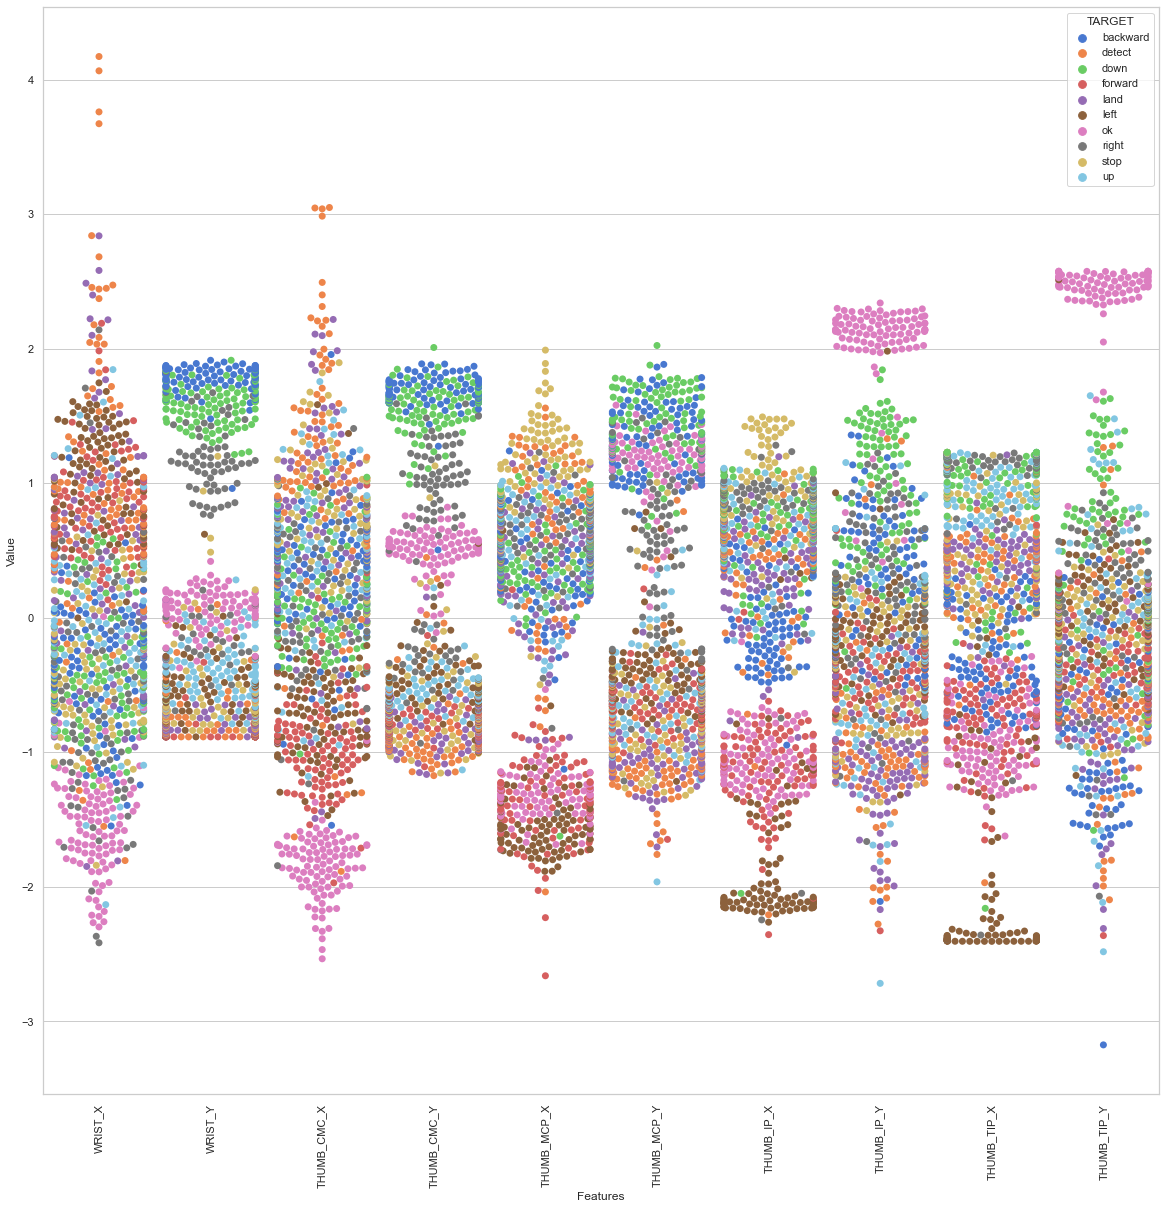

In [9]:
# In swarm plot, I will do three part like violin plot not to make plot very complex appearance
import time

sns.set(style="whitegrid", palette="muted")
data_dia = y
data = df
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([y, data_n_2.iloc[:,0:10]],axis=1)

data = pd.melt(data, id_vars="TARGET",
                     var_name="Features",
                     value_name='Value')
plt.figure(figsize=(20,20))
tic = time.time()

# SMALL_SIZE = 20
# MEDIUM_SIZE = 30
# BIGGER_SIZE = 40
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.xticks(rotation=90)

sns.swarmplot(x="Features", y="Value", hue="TARGET", data=data, size=7)

plt.show()

## PCA

In [10]:
# PCA for Data Visualization

# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# For a lot of machine learning applications it helps to be able to visualize your data.
# Visualizing 2 or 3 dimensional data is not that challenging. However, even the Iris dataset 
# used in this part of the tutorial is 4 dimensional. You can use PCA to reduce that 4 dimensional 
# data into 2 or 3 dimensions so that you can plot and hopefully understand the data better.

# Standardize the Data
# PCA is effected by scale so you need to scale the features in your data before applying PCA.
# Use StandardScaler to help you standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) 
# which is a requirement for the optimal performance of many machine learning algorithms.


from sklearn import preprocessing

# https://scikit-learn.org/stable/modules/preprocessing.html
# An alternative standardization is scaling features to lie between a given minimum and maximum value,
# often between zero and one, or so that the maximum absolute value of each feature is scaled to unit size.
# This can be achieved using MinMaxScaler or MaxAbsScaler, respectively. Problem about StandardScaler is
# when we have new data, and this cannot scale as we want.
min_max_scaler = preprocessing.MinMaxScaler()

# Separating out the features (we exlude the last column that is the target)
x = min_max_scaler.fit_transform(df[df.columns[:-1]])
print(len(x))
print(x[0])

999
[0.3740024  0.98573293 0.6089036  0.9085455  0.68785318 0.75954267
 0.53941783 0.48268903 0.45362397 0.33480683 0.67591165 0.72941128
 0.68158011 0.38690888 0.73751379 0.19529249 0.62728055 0.1212202
 0.35236443 0.72520254 0.41674584 0.37483837 0.61566844 0.07143257
 0.54923762 0.00893837 0.13900137 0.69284463 0.30391045 0.35021831
 0.44565932 0.35431808 0.42347994 0.53836349 0.18959065 0.73142874
 0.33311612 0.42655865 0.45007835 0.47690131 0.44217768 0.53696756]


In [11]:
# PCA Projection to 2D
# The original data has 4 columns (sepal length, sepal width, petal length, and petal width).
# in this section, the code projects the original data which is 4 dimensional into 2 dimensions. 
# I should note that after dimensionality reduction, there usually isn’t a particular meaning assigned to
# each principal component. The new components are just the two main dimensions of variation.

from sklearn.decomposition import PCA

# Define PCA model to use
pca = PCA(n_components=2)

# Fit PCA model to data
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,-1.161725,0.618978
1,-1.189563,0.612605
2,-1.150807,0.651458
3,-1.170504,0.556469
4,-1.168489,0.547464


In [12]:
# Concatenating DataFrame along axis = 1. finalDf is the final DataFrame before plotting the data.
finalDf = pd.concat([principalDf, df[['TARGET']]], axis = 1)
finalDf.head()

,principal component 1,principal component 2,TARGET
0,-1.161725,0.618978,0
1,-1.189563,0.612605,0
2,-1.150807,0.651458,0
3,-1.170504,0.556469,0
4,-1.168489,0.547464,0


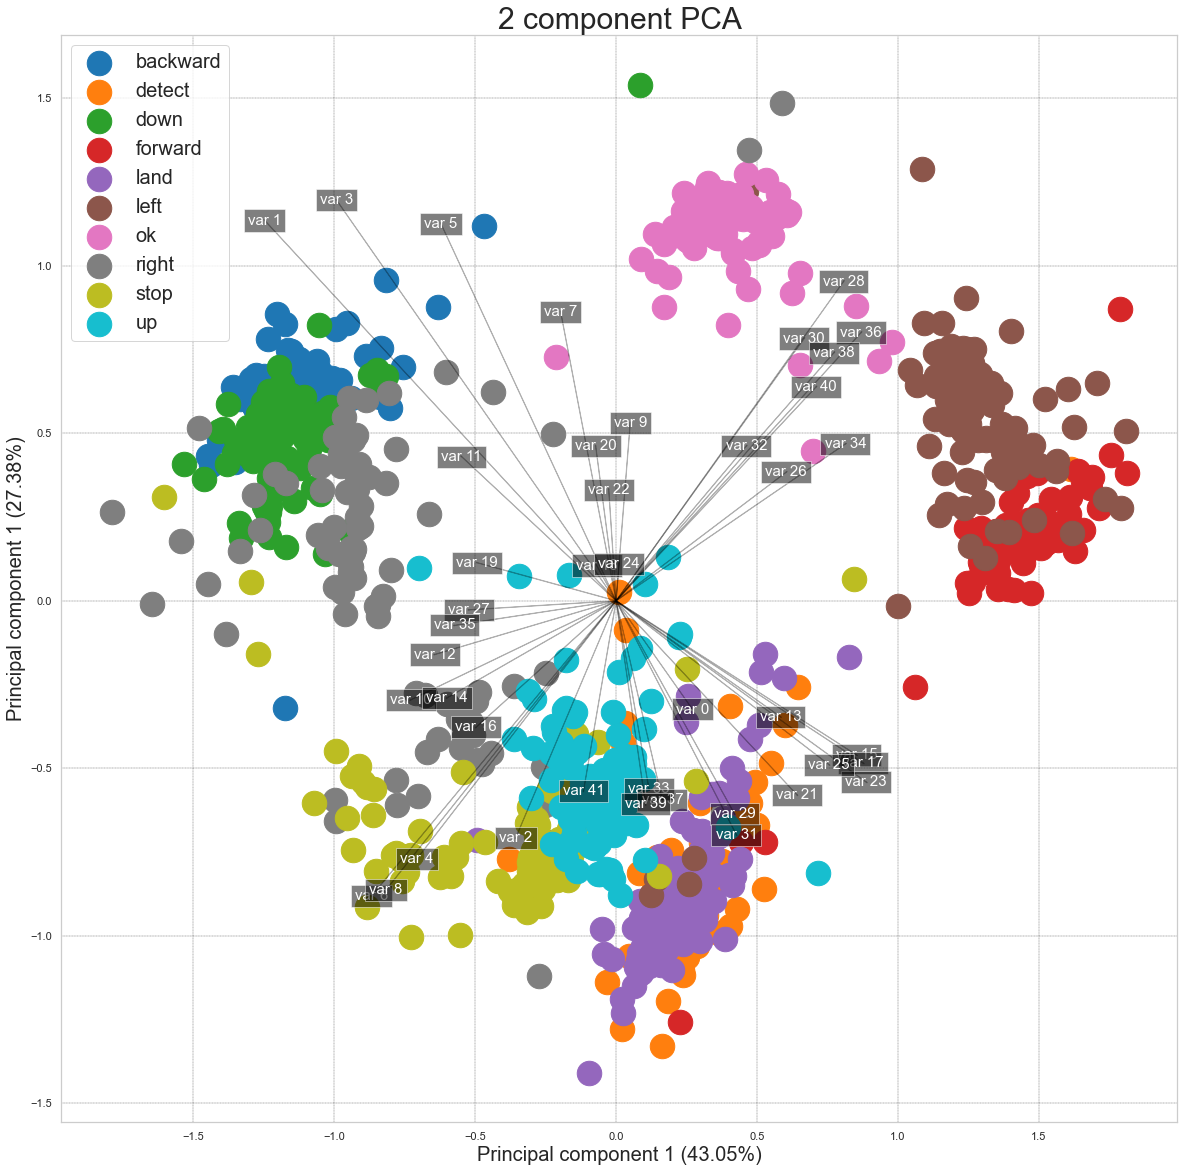

In [13]:
# Visualize 2D Projection of PCA
# This section is just plotting 2 dimensional data. Notice on the graph below that the classes seem well separated from each other.
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(1,1,1) 
ax.set_title('2 component PCA', fontsize = 30)
ax.set_xlabel(f"Principal component 1 ({ round( pca.explained_variance_ratio_[0]*100, 2) }%)", fontsize = 20)
ax.set_ylabel(f"Principal component 1 ({ round( pca.explained_variance_ratio_[1]*100, 2) }%)", fontsize = 20)

targets = list(np.arange(0,10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['TARGET'] == target
    ax.scatter(finalDf.loc[indicesToKeep, "principal component 1"]
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 600)

labels = [f"var {s}" for s in list(np.arange(0, df.shape[1]))]
coeff = np.transpose(pca.components_[0:2, :])
n = coeff.shape[0]
for i in range(n):
    scaleFac = 4
    plt.arrow(0, 0, coeff[i,0] * scaleFac, coeff[i,1] * scaleFac,color = 'black', alpha = 0.25, linewidth=1)
    plt.text(coeff[i,0] * scaleFac, coeff[i,1] * scaleFac, labels[i], color = 'white', ha = 'center', va = 'center', fontsize=15, bbox=dict(facecolor='black', alpha=0.5))

ax.legend(TARGET, fontsize = 20)
ax.grid(b=False, color='black', linestyle='--',  linewidth=0.3)

In [14]:
# The explained variance tells you how much information (variance) can be attributed to each of the principal components. 
# This is important as while you can convert 4 dimensional space to 2 dimensional space, you lose some of the variance (information) when you do this. 
# By using the attribute explained_variance_ratio_, you can see that the first principal component (so the first value in output) contains a certain value of the variance
# and the second principal component contains another value of the variance, smaller. Together, the two components contain (the sum of the two values * 100) of the information.
pca.explained_variance_ratio_

array([0.43051783, 0.27381263])

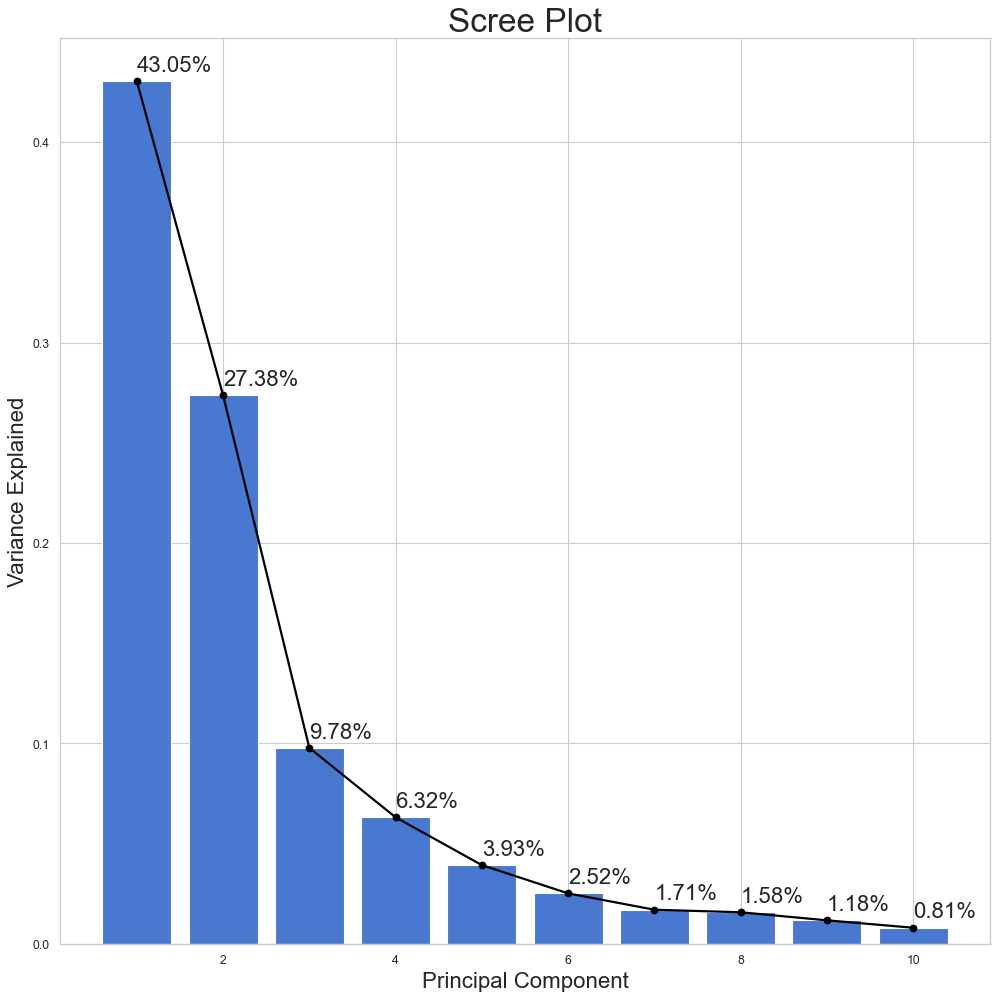

[0.43051783 0.27381263 0.09781129 0.06316803 0.03931891 0.0252067
 0.01705308 0.0157829  0.01175889 0.00806331]


In [15]:
# We’ll calculate the percentage of total variance explained by each principal component and use matplotlib to create a scree plot:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)

PC_values = np.arange(pca.n_components_) + 1
fig, ax = plt.subplots(figsize=(15,15), dpi=80, ncols=1, nrows=1)
ax.bar(PC_values, pca.explained_variance_ratio_)

plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='black')

# Print Values 
for i in range(len(PC_values)):
    ax.annotate(f"{ round( pca.explained_variance_ratio_[i]*100, 2) }%", (PC_values[i], pca.explained_variance_ratio_[i]+0.005), fontsize=20)
    
plt.title('Scree Plot', fontsize = 30)
plt.xlabel('Principal Component', fontsize = 20)
plt.ylabel('Variance Explained', fontsize = 20)

# The x-axis displays the principal component and the y-axis displays the percentage of total variance explained by each individual principal component.
plt.show()
print(pca.explained_variance_ratio_)

In [16]:
# We take just only the 6 principal components because they descrive the 92% of variance
pc6 = principalComponents[:,:6]
principalDf = pd.DataFrame(data = pc6, columns = [f"PC{val}" for val in range(6)])
finalDf = pd.concat([principalDf, df[['TARGET']]], axis = 1)

finalDf.head()

,PC0,PC1,PC2,PC3,PC4,PC5,TARGET
0,-1.161725,0.618978,0.442459,0.464411,0.156099,0.092248,0
1,-1.189563,0.612605,0.426046,0.499759,0.166349,0.078102,0
2,-1.150807,0.651458,0.378716,0.546479,0.024265,0.148847,0
3,-1.170504,0.556469,0.458207,0.497968,0.028624,0.054938,0
4,-1.168489,0.547464,0.432579,0.541367,0.009066,0.037577,0


In [17]:
# Split the dataset
trainPCA = finalDf.sample(frac=0.75,random_state=200) #random state is a seed value
testPCA = finalDf.drop(train.index)
trainPCA_y = trainPCA.pop('TARGET')
testPCA_y = testPCA.pop('TARGET')

# 2. Building the Model A
And now we are ready to choose a model. For classification tasks there are variety of different estimators/models that we can pick from. We choose:

- DNNClassifier (Deep Neural Network)

We can choose either model but the DNN seems to be the best choice.

## Input Function
Remember that nasty input function we created earlier. Well we need to make another one here! Fortunatly for us this one is a little easier to digest.

In [18]:
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))

In [19]:
MODEL_PATH = os.path.join("Tensorflow", "workspace", "models", "my_hand_gesture_model_test")

In [20]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between len(TARGET) classes.
    n_classes=len(TARGET),
    activation_fn=lambda x: tf.nn.leaky_relu(x, alpha=0.01),
    optimizer=lambda: tf.keras.optimizers.Adam(
           learning_rate=tf.compat.v1.train.exponential_decay(
               learning_rate=0.1,
               global_step=tf.compat.v1.train.get_global_step(),
               decay_steps=10000,
               decay_rate=0.96)
       ),
    model_dir= MODEL_PATH)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'Tensorflow\\workspace\\models\\my_hand_gesture_model_test', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Training

In [21]:
classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=3000)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into Tensorflow\workspace\models\my_hand_gesture_model_test\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 2.282799, step = 0
INFO:tensorflow:global_step/sec: 56.8472
INFO:tensorflow:loss = 0.028357834, step = 100 (1.759 sec)
INFO:tensorflow:global_step/sec: 70.369
INFO:tensorflow:loss = 0.004598044, step = 200 (1.421 sec)
INFO:tensorflow:global_step/sec: 96.9877
INFO:tensorflow:loss = 0.028355313, step = 300 (1.032 sec)
INFO:tens

## Export Model

In [22]:
# To export model
feature_spec = tf.feature_column.make_parse_example_spec(my_feature_columns)
export_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)
export_path = classifier.export_saved_model(MODEL_PATH, export_input_fn, as_text=True)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: ['serving_default', 'classification']
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test\model.ckpt-3000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: Tensorflow\workspace\models\my_hand_gesture_model_test\temp-1643290624\saved_model.pbtxt


## Load Model

In [23]:
# Loading the estimator
predict_fn = tf.saved_model.load(export_path).signatures['predict']

In [24]:
# Convert input data into serialized Example strings.
examples = []
for index, row in test.iterrows():
    feature = {}
    for col, value in row.iteritems():
        feature[col] = tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
    example = tf.train.Example(
        features=tf.train.Features(
            feature=feature
        )
    )
    examples.append(example.SerializeToString())

# Convert from list to tensor
examples = tf.constant(examples)

print(test)
print(feature)

      WRIST_X   WRIST_Y  THUMB_CMC_X  THUMB_CMC_Y  THUMB_MCP_X  THUMB_MCP_Y  \
0   -0.259707  0.965687     0.207766     0.820993     0.374721     0.375781   
2   -0.321922  0.946766     0.099888     0.775762     0.236692     0.342551   
6   -0.382369  0.904317     0.055617     0.792012     0.246535     0.365256   
7   -0.400819  0.916157     0.059936     0.792540     0.262218     0.354262   
10  -0.426505  0.904485     0.036768     0.783152     0.246344     0.352970   
..        ...       ...          ...          ...          ...          ...   
987 -0.261952 -0.881557     0.207466    -0.690855     0.544861    -0.441477   
990 -0.429525 -0.630162     0.057222    -0.508476     0.452703    -0.173838   
993 -0.524475 -0.384897    -0.269111    -0.529234     0.141693    -0.540336   
995 -0.596513 -0.802604    -0.327698    -0.910130    -0.005120    -0.883248   
996 -0.402409 -0.629288     0.015719    -0.563268     0.411840    -0.365207   

     THUMB_IP_X  THUMB_IP_Y  THUMB_TIP_X  THUMB_TIP

In [25]:
# https://stackoverflow.com/questions/46766606/how-i-get-accurcy-graphnot-dot-like-loss-graph-in-tensorboard

# make predictions of all testset
predictions = predict_fn(examples=examples)
print(predictions)

{'all_classes': <tf.Tensor: shape=(250, 10), dtype=string, numpy=
array([[b'0', b'1', b'2', ..., b'7', b'8', b'9'],
       [b'0', b'1', b'2', ..., b'7', b'8', b'9'],
       [b'0', b'1', b'2', ..., b'7', b'8', b'9'],
       ...,
       [b'0', b'1', b'2', ..., b'7', b'8', b'9'],
       [b'0', b'1', b'2', ..., b'7', b'8', b'9'],
       [b'0', b'1', b'2', ..., b'7', b'8', b'9']], dtype=object)>, 'class_ids': <tf.Tensor: shape=(250, 1), dtype=int64, numpy=
array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [26]:
# print results
for idx, resultPred in enumerate(predictions["class_ids"]):
    class_id = resultPred[0]
    probability = predictions['probabilities'][idx][class_id]
    print(probability)
    print(f"\tPrediction is {TARGET[class_id]} {100 * probability :.2f}%")
    print(f"\tExpected: {TARGET[test_y.iloc[idx]]}")

tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expected: backward
tf.Tensor(1.0, shape=(), dtype=float32)
	Prediction is backward 100.00%
	Expecte

## Evaluating model performance

https://www.kaggle.com/riteshsinha/tensorflow-2-classifying-tumors-deep-learning

https://www.kaggle.com/karthickaravindan/dnnclassifier

In [27]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [28]:
# Prediction is done here now.
predictions = list(predict_fn(examples=examples)["class_ids"].numpy().T[0])

In [29]:
# Build Confusion Matrix
cm = confusion_matrix(test_y, predictions)
print(cm)

[[28  0  1  0  0  0  0  0  0  0]
 [ 0 30  0  0  1  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  1  0  0]
 [ 0  0  0 29  0  0  0  0  0  0]
 [ 0  1  0  0 19  1  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0 23  0  0  0]
 [ 0  0  0  0  0  0  0 20  3  0]
 [ 0  0  0  0  0  0  0  1 17  0]
 [ 0  0  0  0  1  0  0  1  1 22]]


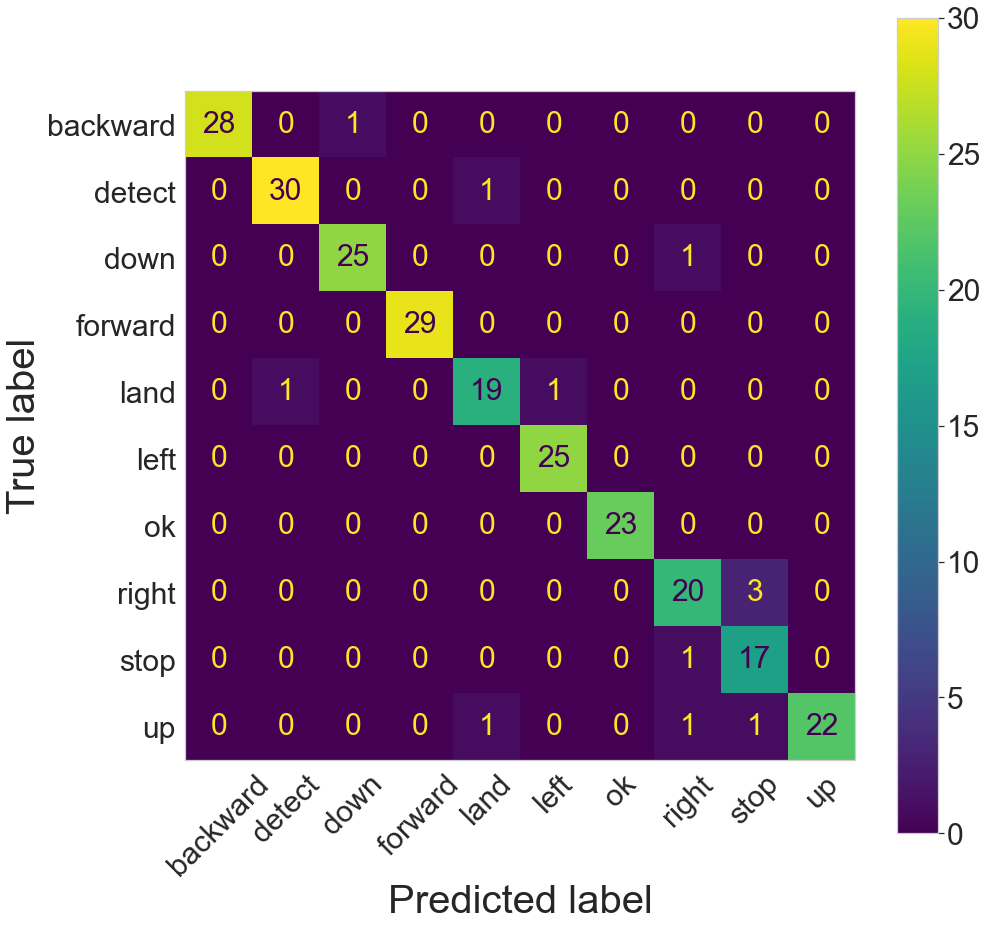

In [30]:
# https://stackoverflow.com/questions/67636940/confusionmatrixdisplay-scikit-learn-plot-labels-out-of-range
SMALL_SIZE = 30
MEDIUM_SIZE = 40
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=TARGET)
fig, ax = plt.subplots(figsize=(15,15)) # set size
cmp.plot(ax=ax, xticks_rotation=45, )

ax.grid(False)
plt.show()

In [31]:
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       0.97      0.97      0.97        31
           2       0.96      0.96      0.96        26
           3       1.00      1.00      1.00        29
           4       0.90      0.90      0.90        21
           5       0.96      1.00      0.98        25
           6       1.00      1.00      1.00        23
           7       0.87      0.87      0.87        23
           8       0.81      0.94      0.87        18
           9       1.00      0.88      0.94        25

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250



In [32]:
accuracy_score(test_y, predictions, normalize=True, sample_weight=None)

0.952

In [33]:
# tensorboard --logdir .
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False), steps=1)

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))
eval_result

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-01-27T14:37:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Inference Time : 0.24101s
INFO:tensorflow:Finished evaluation at 2022-01-27-14:37:10
INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.952, average_loss = 0.45454103, global_step = 3000, loss = 0.45454103
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: Tensorflow\workspace\models\my_hand_gesture_model_test\model.ckpt-3000

Test set accuracy: 0.952



{'accuracy': 0.952,
 'average_loss': 0.45454103,
 'loss': 0.45454103,
 'global_step': 3000}

## Predictions
Now that we have a trained model it's time to use it to make predictions. I've written a little script below that allows you to type the features of a flower and see a prediction for its class.

In [34]:
def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = CSV_COLUMN_NAMES[:-1]
predict = {}

for rowNum in range(5):
    expected = TARGET[test_y.iloc[rowNum]]
    for idx, feature in enumerate(features):
      predict[feature] = [test.iloc[rowNum][idx]] #to predict the first row of test

    predictions = classifier.predict(input_fn=lambda: input_fn(predict))
    for pred_dict in predictions:
        class_id = pred_dict['class_ids'][0]
        probability = pred_dict['probabilities'][class_id]

        print("\n")
        print('Prediction is "{}" ({:.1f}%)'.format(
            TARGET[class_id], 100 * probability))
        print(f"Expected is {expected}")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Prediction is "backward" (100.0%)
Expected is backward
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Prediction is "backward" (100.0%)
Expected is backward
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorf

# 3. Building the Model B (PCA)

## Input Function

In [35]:
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    print(features)

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

# Feature columns describe how to use the input.
my_feature_columns_PCA = []
for key in trainPCA.keys():
    my_feature_columns_PCA.append(tf.feature_column.numeric_column(key=key))

In [36]:
MODEL_PATH_PCA = os.path.join("Tensorflow", "workspace", "models", "my_hand_gesture_model_test_PCA")

# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifierPCA = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns_PCA,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between len(TARGET) classes.
    n_classes=len(TARGET),
    activation_fn=lambda x: tf.nn.leaky_relu(x, alpha=0.01),
    optimizer=lambda: tf.keras.optimizers.Adam(
           learning_rate=tf.compat.v1.train.exponential_decay(
               learning_rate=0.1,
               global_step=tf.compat.v1.train.get_global_step(),
               decay_steps=10000,
               decay_rate=0.96)
       ),
    model_dir= MODEL_PATH_PCA)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'Tensorflow\\workspace\\models\\my_hand_gesture_model_test_PCA', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Training

In [37]:
# Train model
classifierPCA.train(
    input_fn=lambda: input_fn(trainPCA, trainPCA_y, training=True),
    steps=3000)

          PC0       PC1       PC2       PC3       PC4       PC5
674  0.352680  1.163580 -0.449106 -0.195983 -0.421509 -0.182972
233 -1.119982  0.507562  0.372423 -0.115972 -0.023346 -0.110080
739 -0.134554 -0.545473  0.377870 -0.390768 -0.669383  0.004103
865 -0.307426 -0.780640 -0.370977  0.432002 -0.129030 -0.283294
523  1.352544  0.207701  0.536389 -0.143339  0.249334  0.057182
..        ...       ...       ...       ...       ...       ...
194 -0.281452 -0.867778 -0.132349 -0.145604 -0.022259  0.057371
853 -0.208277 -0.832784 -0.101276  0.031762 -0.116505 -0.171926
616  0.251716  1.076232 -0.520348 -0.375542 -0.325278 -0.300605
19  -1.176306  0.696081  0.095561  0.579271 -0.133054  0.077996
44  -0.468374  1.119976 -0.061783  0.850593  0.006081  0.392295

[749 rows x 6 columns]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow

## Export Model

In [38]:
# To export PCA model
feature_spec = tf.feature_column.make_parse_example_spec(my_feature_columns_PCA)
export_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)
export_path_PCA = classifierPCA.export_saved_model(MODEL_PATH_PCA, export_input_fn, as_text=True)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: ['serving_default', 'classification']
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test_PCA\model.ckpt-3000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: Tensorflow\workspace\models\my_hand_gesture_model_test_PCA\temp-1643290646\saved_model.pbtxt


## Load Model

In [39]:
predict_fn = tf.saved_model.load(export_path_PCA).signatures['predict']

# Convert input data into serialized Example strings.
examples = []
for index, row in testPCA.iterrows():
    feature = {}
    for col, value in row.iteritems():
        feature[col] = tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
    example = tf.train.Example(
        features=tf.train.Features(
            feature=feature
        )
    )
    examples.append(example.SerializeToString())

# Convert from list to tensor
examples = tf.constant(examples)

## Evaluating model performance

In [40]:
# Prediction is done here now.
predictions = list(predict_fn(examples=examples)["class_ids"].numpy().T[0])

In [41]:
# Build Confusion Matrix
cm = confusion_matrix(testPCA_y, predictions)
print(cm)

[[25  0  4  0  0  0  0  0  0  0]
 [ 0 27  0  0  3  0  0  0  0  1]
 [ 0  0 25  0  0  0  0  1  0  0]
 [ 0  1  0 27  0  1  0  0  0  0]
 [ 0  0  0  1 19  0  0  0  0  1]
 [ 0  0  0  1  0 24  0  0  0  0]
 [ 0  0  0  0  0  0 23  0  0  0]
 [ 0  0  2  0  0  0  0 19  2  0]
 [ 0  0  0  0  0  0  0  0 17  1]
 [ 0  0  0  0  1  0  0  0  0 24]]


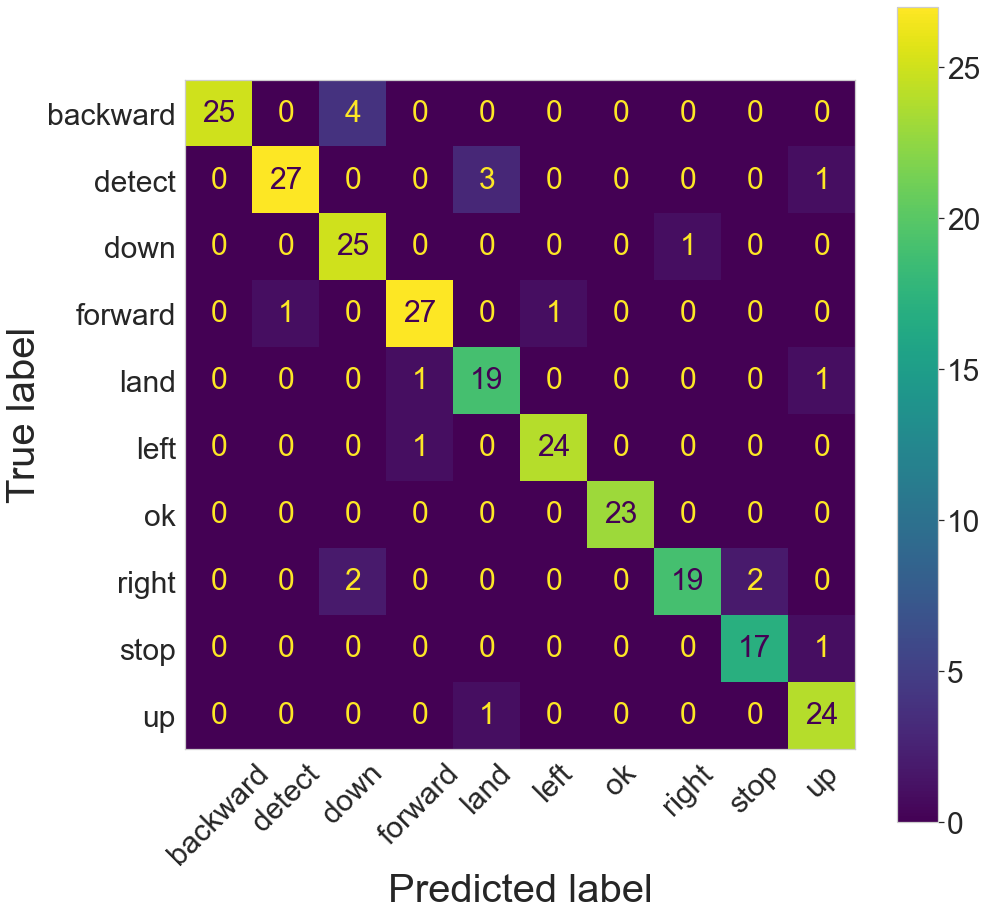

In [42]:
# Plot Confusion Matrix
SMALL_SIZE = 30
MEDIUM_SIZE = 40
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=TARGET)
fig, ax = plt.subplots(figsize=(15,15)) # set size
cmp.plot(ax=ax, xticks_rotation=45)

ax.grid(False)
plt.show()

In [43]:
# Evaluation PCA
# tensorboard --logdir .
eval_result = classifierPCA.evaluate(
    input_fn=lambda: input_fn(testPCA, testPCA_y, training=False), steps=1)

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))
eval_result

          PC0       PC1       PC2       PC3       PC4       PC5
0   -1.161725  0.618978  0.442459  0.464411  0.156099  0.092248
2   -1.150807  0.651458  0.378716  0.546479  0.024265  0.148847
6   -1.180564  0.597699  0.444249  0.551376 -0.043627  0.050472
7   -1.186002  0.599764  0.420964  0.553758 -0.033194  0.088816
10  -1.179574  0.588934  0.442200  0.542946 -0.065542  0.068401
..        ...       ...       ...       ...       ...       ...
987 -0.017036 -0.817958 -0.714496  0.109625  0.181318  0.192767
990 -0.289877 -0.293651 -0.832612 -0.015743  0.012745  0.412851
993 -0.227316 -0.724685 -0.236359  0.376822 -0.027697  0.123601
995  0.717737 -0.813474  0.450252  0.197566 -0.260324  0.583249
996  0.101639 -0.773748 -0.207845 -0.317853 -0.155577  0.149608

[250 rows x 6 columns]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-01-27T14:37:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters fr

{'accuracy': 0.92,
 'average_loss': 1.583043,
 'loss': 1.583043,
 'global_step': 3000}

## Predictions

In [44]:
# Predictions
def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = list(finalDf.columns[:-1])
predict = {}

for rowNum in range(5):
    expected = TARGET[testPCA_y.iloc[rowNum]]
    for idx, feature in enumerate(features):
      predict[feature] = [testPCA.iloc[rowNum][idx]] #to predict the first row of test

    predictions = classifierPCA.predict(input_fn=lambda: input_fn(predict))
    for pred_dict in predictions:
        class_id = pred_dict['class_ids'][0]
        probability = pred_dict['probabilities'][class_id]

        print("\n")
        print('Prediction is "{}" ({:.1f}%)'.format(
            TARGET[class_id], 100 * probability))
        print(f"Expected is {expected}")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test_PCA\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Prediction is "backward" (100.0%)
Expected is backward
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test_PCA\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Prediction is "backward" (100.0%)
Expected is backward
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test_PCA\model.ckpt-3000
INFO:tensorflow:Running local_init_op.


## Make prediction with PCA model, with real new data

It's important the fact that we need to transform data with min_max_scaler and transform data with pca

In [45]:
rowsNorm = min_max_scaler.transform(df[df.columns[:-1]].iloc[2:4])
rowsTarget = list(df.iloc[2:4].TARGET)

In [46]:
# transform new data using already fitted pca
# (don't re-fit the pca)
rowsPCA = pca.transform(rowsNorm)

In [47]:
# Take just only the first 6 columns
rowsPCAWithColumns = pd.DataFrame(data = rowsPCA[:,:6], columns = [f"PC{val}" for val in range(6)])
rowsPCAWithColumns.head()

,PC0,PC1,PC2,PC3,PC4,PC5
0,-1.150807,0.651458,0.378716,0.546479,0.024265,0.148847
1,-1.170504,0.556469,0.458207,0.497968,0.028624,0.054938


In [48]:
# Predictions
def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = list(rowsPCAWithColumns.columns)
predict = {}

for rowNum in range(rowsPCAWithColumns.shape[0]):
    expected = TARGET[rowsTarget[rowNum]]
    for idx, feature in enumerate(features):
        predict[feature] = [rowsPCAWithColumns.iloc[rowNum][idx]] #to predict the first row of test

    predictions = classifierPCA.predict(input_fn=lambda: input_fn(predict))
    for pred_dict in predictions:
        class_id = pred_dict['class_ids'][0]
        probability = pred_dict['probabilities'][class_id]

        print("\n")
        print('Prediction is "{}" ({:.1f}%)'.format(
            TARGET[class_id], 100 * probability))
        print(f"Expected is {expected}")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test_PCA\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Prediction is "backward" (100.0%)
Expected is backward
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\my_hand_gesture_model_test_PCA\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Prediction is "backward" (100.0%)
Expected is backward
